In [ ]:
from google.colab import files, drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
base_dir = '/content/gdrive/MyDrive/SIBISA-App/Dataset'
train_dir = '/content/gdrive/MyDrive/SIBISA-App/Dataset/train'
val_dir = '/content/gdrive/MyDrive/SIBISA-App/Dataset/val'
test_dir = '/content/gdrive/MyDrive/SIBISA-App/Dataset/test'

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model
from tensorflow.keras import regularizers

%matplotlib inline

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

train_dataset = train_generator.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_dataset = train_generator.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_dataset = test_generator.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb',
)

Found 1196 images belonging to 26 classes.
Found 26 images belonging to 26 classes.
Found 207 images belonging to 26 classes.


In [4]:
resize_and_rescale = Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
], name="data_augmentation")

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
checkpoint_path = "model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True)

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(26, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

In [ ]:
optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-14 22:33:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-14 22:33:10 (91.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset),
    validation_steps=len(val_dataset),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "model_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/model_classification/20230614-223312
Epoch 1/100
38/38 [==============================] - 454s 12s/step - loss: 3.5588 - accuracy: 0.0936 - val_loss: 2.8931 - val_accuracy: 0.5000
Epoch 2/100
38/38 [==============================] - 31s 812ms/step - loss: 2.9313 - accuracy: 0.2375 - val_loss: 2.1429 - val_accuracy: 0.6538
Epoch 3/100
38/38 [==============================] - 31s 803ms/step - loss: 2.3937 - accuracy: 0.3988 - val_loss: 1.4943 - val_accuracy: 0.7692
Epoch 4/100
38/38 [==============================] - 30s 800ms/step - loss: 1.9465 - accuracy: 0.5242 - val_loss: 1.1417 - val_accuracy: 0.8846
Epoch 5/100
38/38 [==============================] - 31s 809ms/step - loss: 1.6537 - accuracy: 0.5987 - val_loss: 0.8404 - val_accuracy: 1.0000
Epoch 6/100
38/38 [==============================] - 32s 827ms/step - loss: 1.3787 - accuracy: 0.6597 - val_loss: 0.6745 - val_accuracy: 0.9615
Epoch 7/100
38/38 [==============================] - 

[INFO] Train Accuracy: 99.91639%
[INFO] Train Loss    : 0.0338663
[INFO] Val Accuracy  : 100.00000%
[INFO] Val Loss      : 0.0188883


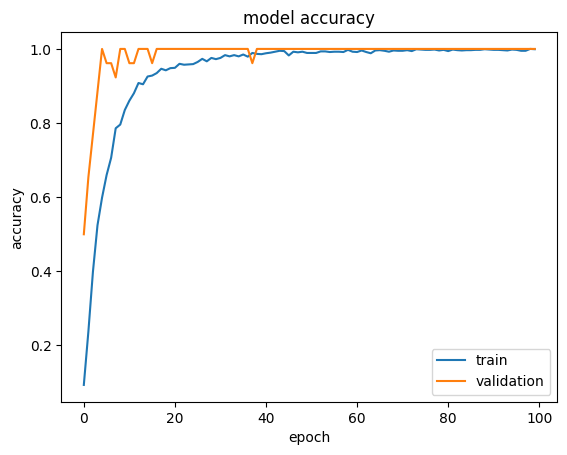

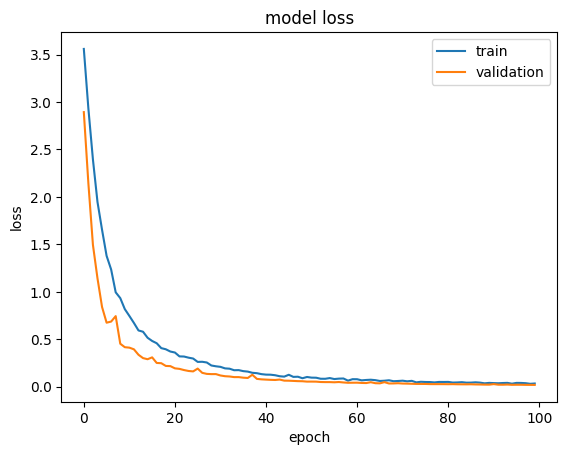

In [ ]:
print("[INFO] Train Accuracy:", "{:.5f}%".format(history.history['accuracy'][-1]*100))
print("[INFO] Train Loss    :", "{:.7f}".format(history.history['loss'][-1]))
print("[INFO] Val Accuracy  :", "{:.5f}%".format(history.history['val_accuracy'][-1]*100))
print("[INFO] Val Loss      :", "{:.7f}".format(history.history['val_loss'][-1]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [ ]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.71080
Test Accuracy: 83.09%


In [ ]:
MODEL_NAME = 'modelv3.h5'
model.save(MODEL_NAME)
TFLITE_MODEL_NAME = "tfliteModel.tflite"
tflite_convert = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_convert.convert()
open(TFLITE_MODEL_NAME, "wb").write(tflite_model)

12464208

In [ ]:
pred = model.predict(test_dataset)
pred = np.argmax(pred,axis=1)

labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:8]}')

7/7 [==============================] - 6s 725ms/step
The first 5 predictions: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']


In [ ]:
train_labels= sorted(os.listdir(train_dir ))
print(train_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
! ls /content/gdrive/My\ Drive/SIBISA-App/Dataset

test  train  val


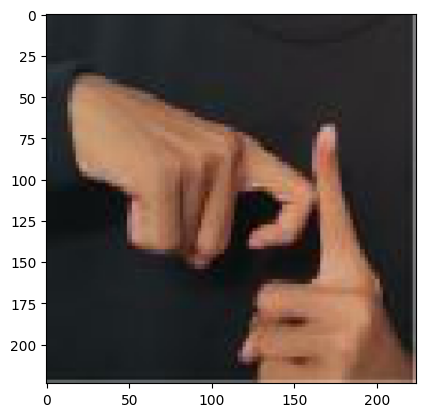

1/1 [==============================] - 2s 2s/step
Actual: K
Predicted: K


In [ ]:
from tensorflow.keras.preprocessing import image
image_dir='/content/gdrive/MyDrive/SIBISA/NewDataset2/test/K/K (3).jpg'

img = image.load_img(image_dir, target_size=(224, 224,3))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
pred = model.predict(images, batch_size=32)
label = np.argmax(pred, axis=1)
print("Actual: "+image_dir.split("/")[-2])
print("Predicted: "+ train_labels[np.argmax(pred)])

In [5]:
MODEL_NAME = 'my_model.h5'

model.save(MODEL_NAME)

model = tf.keras.models.load_model(MODEL_NAME)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.experimental_optimizations = True

tflite_model = converter.convert()

with open('tfliteModel2.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: ignored